- Seq2Seq : 입력과 출력의 길이가 다른 데이터에서 사용
- 어텐션 : 인코더의 모든 시점에서의 은닉상태를 현재의 입력에 반영
- 토큰 : 문자를  숫자로 나타내는 방법 <SOS>, <EOS> 시작과 끝을 나타내는 태그가 존재
- GRU : 셀 상태를 없애고 은닉생태만 이용해서 현재의 정보를 추출

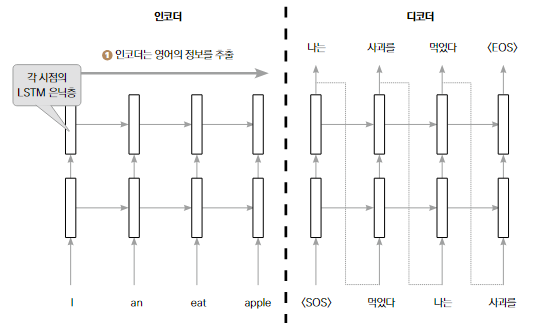

In [ ]:
# 장점 : 이론상 RNN과 LSTM보다 성능이 좋다
# 단점 : 알고리즘이 복잡해서 구현이 어려움, 모든 시점을 고려하기 때문에. 계산량이 많음


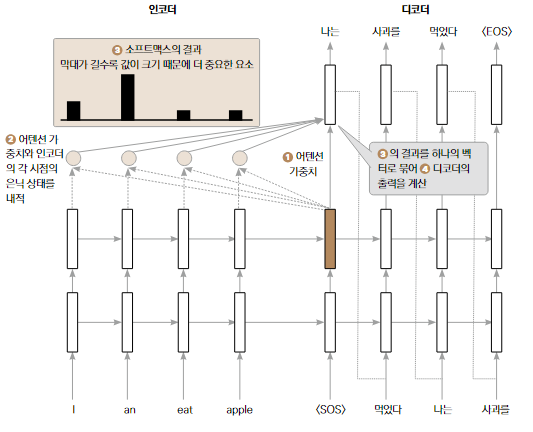

GRU(gated recurrent unit)
  - LSTM을 간략화 시킨 모델,  셀 상태와 은닉생태를 통합한 모델

In [ ]:
# 데이터는 http://www.manythings.org/anki/
# kor-eng.zip 다운로드

In [ ]:
!unzip '/content/kor-eng.zip'

Archive:  /content/kor-eng.zip
  inflating: _about.txt              
  inflating: kor.txt                 


In [ ]:
import string
li = []
with open('/content/kor.txt','r') as kor_file:
  lines = kor_file.read().split('\n')
  for line in lines:
    # 특수문자를 지우고 모든 문자를 소문자로 변경
    txt = "".join(v for v in line if v not in string.punctuation).lower()
    li.append( '\t'.join(txt.split('\t')[:2]) )

In [ ]:
li[:5]

['go\t가', 'hi\t안녕', 'run\t뛰어', 'run\t뛰어', 'who\t누구']

In [ ]:
# 학습용 데이터 만들기
import numpy as np
import torch
from torch.utils.data.dataset import Dataset

In [ ]:
def get_BOW(corpus):
  BOW = {'<SOS>':0,"<EOS>":1}
  for line in corpus:
    for word in line.split():
      if word not in BOW.keys():
        BOW[word] = len(BOW.keys())
  return BOW

In [ ]:
get_BOW(["Tom has low blood pressure"])

{'<SOS>': 0,
 '<EOS>': 1,
 'Tom': 2,
 'has': 3,
 'low': 4,
 'blood': 5,
 'pressure': 6}

In [ ]:
# 데이터 셋
class Eng2Kor(Dataset):
  def __init__(self,pth2txt='/content/kor.txt'):
    self.eng_corpus = []  # 영어문장이 들어가는 변수
    self.kor_corpus = []  # 한글문장이 들어가는 변수

    with open(pth2txt,'r') as f:
      lines = f.read().split("\n")
      for line in lines:
        try:
          # 특수문자를 지우고 모든 문자를 소문자로 변경
          txt = "".join(v for v in line if v not in string.punctuation).lower()
          engtxt = txt.split('\t')[0]
          kortxt = txt.split('\t')[1]

          # 길이가 10이하인 문장만 사용
          if len(engtxt.split()) <=10 and len(kortxt.split()) <= 10:
            self.eng_corpus.append(engtxt)
            self.kor_corpus.append(kortxt)
        except Exception as e:
          print(e)

    self.engBOW = get_BOW(self.eng_corpus)
    self.korBOW = get_BOW(self.kor_corpus)

  # 문장을 단어별로 분리하고 마지막에 <EOS> 추가
  def gen_seq(self, line):
    seq = line.split()
    seq.append("<EOS>")
    return seq
  def __len__(self):
    return len(self.eng_corpus)
  def __getitem__(self, index):
    # 문자열로 되어 있는 문장을 숫자 표현으로 변경
    data =  np.array([self.engBOW[txt] for txt in self.gen_seq(self.eng_corpus[index])])
    label = np.array([self.korBOW[txt] for txt in self.gen_seq(self.kor_corpus[index])])
    return data, label

In [ ]:
Eng2Kor()
# temp = 'Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.	의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지. 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면, 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고, 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면, 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기억하고 있다면, 딱 맞는 남자는 지구가 생겨난 이래로 딱 맞는 여자를 단 한번도 만난 적이 없을 수도 있을 거라는 사실을 쉽게 눈치챌 수 있을 거야.	CC-BY 2.0 (France) Attribution: tatoeba.org #7697649 (RM) & #8375041 (Eunhee)'
# txt = "".join(v for v in temp if v not in string.punctuation).lower()
# txt.split('\t')[1]

list index out of range


In [ ]:
# 데이터 로더 : 데이터셋의 문장을 한 문장씩 불러옴
# yield : return 문과 비슷하게 값을 반환 , 반복적으로 반한하는데 사용
def loader(dataset):
  for i in range(len(dataset)):
    data,label =  dataset[i]
    yield torch.tensor(data), torch.tensor(label)

In [ ]:
temp_dataset = [(1,2),(3,4),(5,6),(7,8)]
temp_loader = loader(temp_dataset)
for data,label in temp_loader:
  print(data,label)

tensor(1) tensor(2)
tensor(3) tensor(4)
tensor(5) tensor(6)
tensor(7) tensor(8)


인코더
  - 입력 -> 입베디드층 -> GRU층 -> 출력

In [ ]:
import torch.nn as nn
class Encoder(nn.Module):
  def __init__(self, input_size , hidden_size) -> None:
    super(Encoder,self).__init__()
    self.embedding = nn.Embedding(input_size,hidden_size)
    self.gru = nn.GRU(hidden_size,hidden_size)
  def forward(self, x, h):
    # 배치 차원과 시계열 차원 추가
    x = self.embedding(x).view(1,1,-1)
    output,hidden =  self.gru(x,h)
    return output,hidden

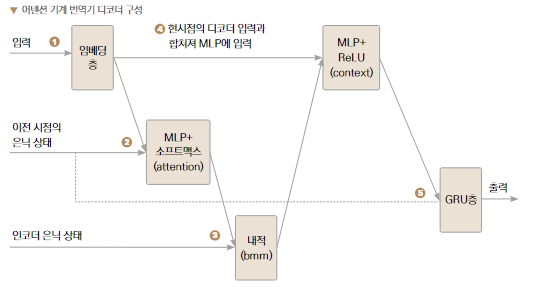

In [ ]:
# 디코더
class Decoder(nn.Module):
  def __init__(self,hidden_size,output_size,drop_rate = 0.1,max_lengh = 11 ):
    super(Decoder,self).__init__()
    # 임베딩층 정의
    self.embedding = nn.Embedding(output_size,hidden_size)
    # 어텐션 가중치를 계산하기 위한 mlp 층
    self.attention = nn.Linear(hidden_size*2,max_lengh)
    # 특징 추출을 위한 mlp층
    self.context = nn.Linear(hidden_size*2,hidden_size)
    # 과적합을 피하기위해 드랍아웃층
    self.dropout = nn.Dropout(drop_rate)
    # gru층
    self.gru = nn.GRU(hidden_size,hidden_size)
    # 단어분류를 위한 mlp층
    self.out = nn.Linear(hidden_size,output_size)
    # 활성화 함수
    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self,x,h,encoder_outputs):
    # 1. 입력을 밀집표현
    x = self.embedding(x).view(1,1,-1)
    x = self.dropout(x)
    # 2. 어텐션의 가중치 계산
    atten_weight = self.softmax(
        self.attention(torch.cat(x[0],h[0]), -1)
    )
    # 3. 어텐션의 가중치와 인코더의 출력을 내적
    atten_applied = torch.bmm(atten_weight.unsqueeze(0),encoder_outputs.unsqueeze(0) )
    # 4. 인코더의 각 시점의 중요도와 밀집표현을 합쳐 mlp층으로 특징 추출
    output =  torch.cat( (x[0],atten_applied[0]),1 )
    output = self.context(output).unsqueeze(0)
    output = self.relu(output)
    # 5. gru층으로 입력
    output,hidden =  self.gru(output,h)
    # 6. 예측된 단어 출력
    output = self.out(output[0])
    return output

In [ ]:
import random
import tqdm
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Eng2Kor()
encoder=Encoder(input_size=len(dataset.engBOW), hidden_size=64).to(device)
decoder=Decoder(64,len(dataset.korBOW)).to(device)
encoder_optim = Adam(encoder.parameters())
decoder_optim = Adam(decoder.parameters())

list index out of range


In [ ]:
for epoch in range(2):  # 200
  iter = tqdm.tqdm(loader(dataset))
  total_loss = 0
  for data,label  in iter:
    data = torch.tensor(data, dtype = torch.long).to(device)
    label = torch.tensor(label, dtype = torch.long).to(device)
    # 인코더의 초기 은닉상태
    encoder_hidden = torch.zeros(1,1,64).to(device)
    # 인코더의 모든시점의 변수를 저장
    encoder_outputs = torch.zeros(1,1,64).to(device)  #디코더에서 인코더의 모든시점의 변수를 사용

    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    loss = 0
    # 인코더 동작
    for ei in range(len(data)):
      # 한 단어씩 인코더에 입력
      encoder_output, encoder_hidden =  encoder(data[ei],encoder_hidden)
      # 인코더의 은닉상태 저장
      encoder_outputs[ei] = encoder_output[0,0]
    decoder_input = torch.tensor([[0]]).to(device)
    # 인코더의 마지막 은닉상태를 디코더의 초기 은닉상태로 저장
    decoder_hidden = encoder_hidden

In [ ]:
# Teacher forcing